# SVD Based PCA: The Rules and When to Break Them


Humans are exceptional at discerning boundaries. Consider leisure search puzzles in the morning paper. These are supposed to be fun and relatively simple! Yet, if the dimensions were to increase past three to 20, 30, or 40 directions, it would become an intractable task to draw boundaries between sets or words.  

In machine learning, we attempt to move past this human boundary by leveraging technology. We extract difficult partitions and define shapes through principal component analysis (PCA). Reduce complexity. Heighten clarity.  

For most,  dimension reduction, singular value decomposition (SVD), and PCA are old news. In some routinized way, we preprocess, implement,  project our data onto the major axes of variance, and move on with our project. However, _why_ do these specific preprocessing steps from the outset even work? More importantly, how did the authors of a geospatial research article¹ get better results by not using them? 

[¹https://opengeospatialdata.springeropen.com/articles/10.1186/s40965-017-0029-0](https://opengeospatialdata.springeropen.com/articles/10.1186/s40965-017-0029-0)


To outline this discussion, the primary goal is to consider the usefulness of PCA and to unravel the codified preprocessing steps associated with it. More specifically, we address a quick example of SVD based PCA and reason through the typical implementation of mean-centering and scaling. We then walk through the basic details of remote sensing in order to understand a poignant research application of PCA.  In their conclusion, a team of researches used data driven decisions to neglect both mean-centering and scaling, and our objective is to understand why. Finally, I end the discussion with commentary on the nature of standard practices, reasons for them, and connect this broadly to the No Free Lunch Theorem.


### The Principles of PCA: a coded example


Principal Component Analysis, or PCA, reduces the dimensions of large data sets, by transforming a large set of variables into a smaller set that still contains most of the original information.  In other words, PCA finds the directions where the data is most prominently oriented (where the variance is highest) and then pushes the data points into those axes. 

To clarify how this works in practice, below is a coded visualization.  Here, we go from two dimensions to one dimension, and then re-project the data into  two dimensional space to create a scatter plot. 

First, take a look at the original data with a clear direction of maximal variance. The positively trending data will be the clear winner for first principal component.

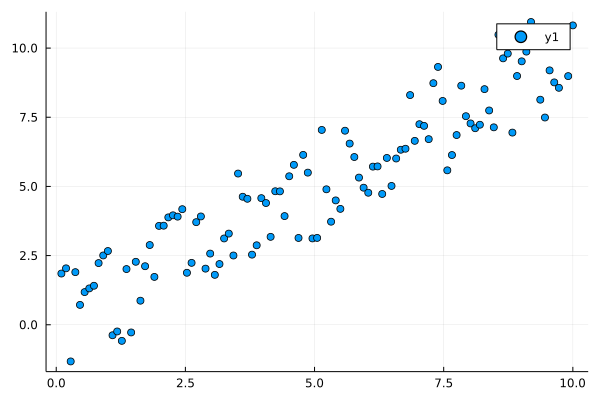

In [2]:
using Distributions, Statistics, Random, Plots, LinearAlgebra
Random.seed!(13) 
xs = [0.1:0.09:10;] 
ys = [(x .+rand(Uniform(-2,2))) for x in xs] #create random noise along y=mx+b plot
scatter(xs,ys)

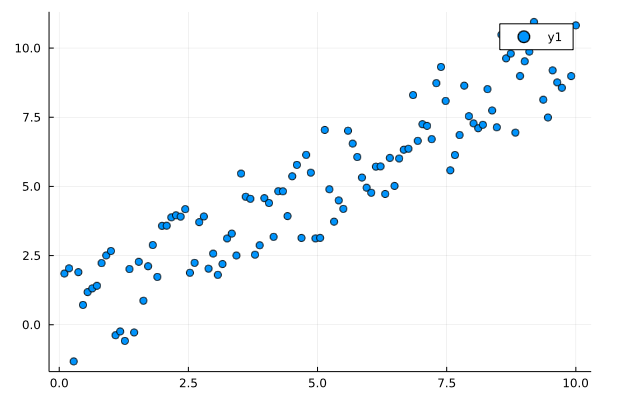

Now, take a look at an SVD-based PCA applied to this data. We can use the main direction of variance  to squash each point down to that data-defined axis. The idea is that we preserve the most useful information (maximal variance) while diminishing less important directions. Effectively,  we treat low-meaning data like we would noise, which is data that is altered by machine and/or collection errors. To  be clear, the axes that we eliminate in PCA _do_ contain meaning, but that information is the price we pay for a clearer understanding of the more important components. 

[5.050000000000001 5.071024328958571]


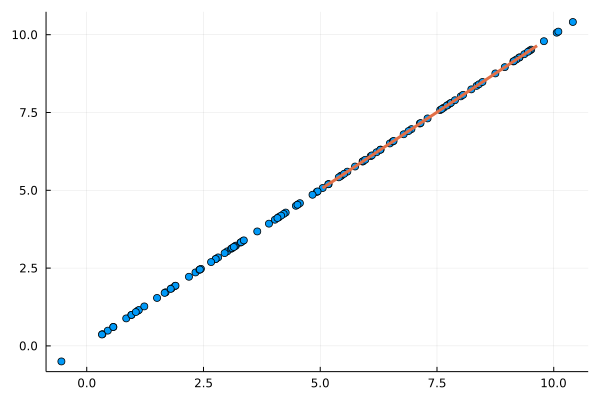

In [3]:
X = hcat(xs,ys) #create matrix of x,y pairs
μ = mean(X, dims = 1) 
U,Σ,V = svd(X .-μ); #perform SVD on de-meaned matix 
println(μ)
#plot the new data along 1st component
scatter([Tuple(μ' + V[1,:]*V[1,:]'*(x-μ')) for x in eachrow(X)])
plot!([Tuple(μ), Tuple(μ' + √(Σ[1])*V[:,1])], linewidth = 3, legend = false)

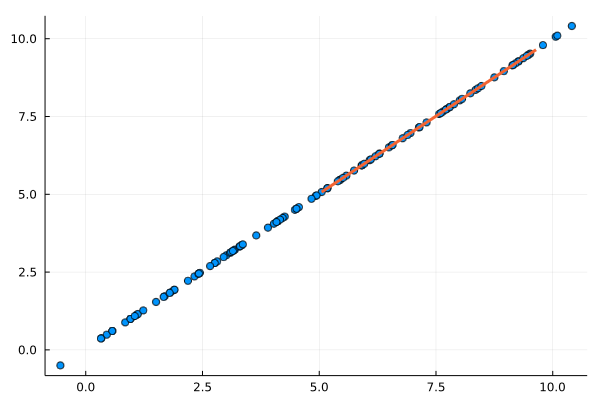

While two dimensions might seem trivial, there is a great utility in reducing a 300-dimensional space to a 10-dimensional space, or a 784-dimensional space to a 100-dimensional space. Perhaps it's useful to imagine the ultimate effect is like putting on a pair of glasses. Before, we might see a blur of colors and understand an object generally. However, after we put the glasses on, we see the sharper boundaries that distinguish differences in our field of vision. These boundaries help us make better decisions about our problem.

### PCA Preprocessing: the details explained


The Key Steps of PCA in practice¹  are 1) mean subtraction, 2) standardization, and 3) eigen decomposition/singular value decomposition. The preprocessing in 1) and 2) are the topics of interest because they determine how our results can be interpreted and what our geospatial researchers changed to their own experiement's success.

#### Centering
Stepping toward this goal of delineating major axes of variance, we first recenter out data. This mean subtraction simply provides us with a way to look only at the variance within the dataset.  In practice, we compute the mean and then subtract it from every single data point to ensure that the updated mean of the dataset is now zero. Without centering, instead of the first principal component corresponding to the direction of maximum variance, it could actually represent the mean itself.

Before continuing, it's important to acknowledge what all of this actually signifies. Let's consider actual data and how shifting values in our data dimensions changes things. For small positive values, for example, subtracting the mean forces these data points to now be negative with a larger magnitude than before. In essence, mean centering just gives more importance to these smaller features relative to the others. 

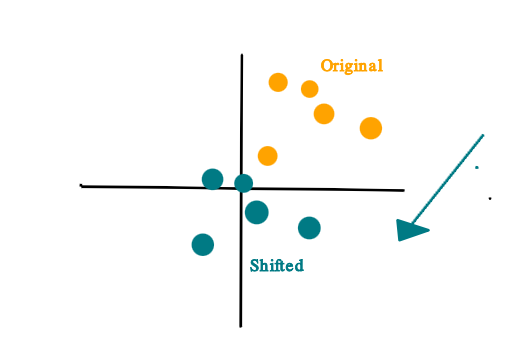

In reality, then, it makes sense that mean subtraction is “not strictly necessary but reduces the risk of numerical problems.”¹ However, centering is often considered necessary and especially important when we consider SVD based PCA. Noted above, the first principal component found by PCA might capture the average of the data rather than the the direction of maximum variance. 

With SVD based PCA,if the data is not centered, the covariance matrix used to decompose the data is not obtained by  $\frac{X^{T}X}{(n-1)}$ , a common way to compute it. Instead, we obtain a matrix that is similar to, but not quite the covariance matrix. The subject has already been discussed at length²,  but the main point is that mean-centering is often considered crucial in SVD based PCA.³

¹[https://mml-book.github.io/book/mml-book.pdf ](https://mml-book.github.io/book/mml-book.pdf )
[² https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca](https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca)
³[http://users.stat.umn.edu/~helwig/notes/datamat-Notes.pdf](http://users.stat.umn.edu/~helwig/notes/datamat-Notes.pdf)
⁴[https://jonathan-hui.medium.com/machine-learning-singular-value-decomposition-svd-principal-component-analysis-pca-1d45e885e491](https://jonathan-hui.medium.com/machine-learning-singular-value-decomposition-svd-principal-component-analysis-pca-1d45e885e491)


We can actually see through a simple example that mean centering _does_ make a difference in SVD output.  While the two matrices below seem fairly similar, the signs of the entries and actual numeric values differ. In other words, the singular vectors (and thus the axes of maximal variance) are not equivalent between the two. 

With mean centering: 
$\begin{bmatrix} 0.7085 & 0.7055711 \\ 0.705711 & -0.7085 \end{bmatrix}$  

Without mean centering:
$\begin{bmatrix} -0.706295 & 0.707918 \\- 0.707918 & -0.706295 \end{bmatrix}$         



In [4]:
U1,Σ1,V1 = svd(X) #same example implemented in code
display(V)
display(V1)

2×2 adjoint(::Matrix{Float64}) with eltype Float64:
 0.7085     0.705711
 0.705711  -0.7085

2×2 adjoint(::Matrix{Float64}) with eltype Float64:
 -0.706295   0.707918
 -0.707918  -0.706295

#### Scaling
The next step in PCA is scaling. In this step we use standardization to isolate true variance. Without scaling, each feature's variance includes both true variance and the **units** of that feature. What this means is best illustrated by example. Let's say we're deciding whether to measure height in centimeters, inches, and meters and have also chosen to not scale our data. 

Take a look at the dummy example below showing that changing the variance of height depends on units. Compared to weight, the height may or may not have maximum variance depending on the units used. However, with scaling, this discrepancy is eliminated.

    Updating registry at `~/.julia/registries/General`
┌ Error: curl_easy_setopt: 48
└ @ Downloads.Curl /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/Downloads/src/Curl/utils.jl:36
┌ Error: curl_easy_setopt: 48
└ @ Downloads.Curl /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/Downloads/src/Curl/utils.jl:36
┌ Error: curl_easy_setopt: 48
└ @ Downloads.Curl /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/Downloads/src/Curl/utils.jl:36
┌ Error: curl_easy_setopt: 48
└ @ Downloads.Curl /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/Downloads/src/Curl/utils.jl:36
┌ Error: curl_easy_setopt: 48
└ @ Downloads.Curl /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/Downloads/src/Curl/utils.jl:36
┌ Error: curl_easy_setopt: 48
└ @ Downloads.Curl /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/Downloads/src/Curl/uti

   Installed MultivariateStats ─ v0.8.0
┌ Error: curl_easy_setopt: 48
└ @ Downloads.Curl /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/Downloads/src/Curl/utils.jl:36
┌ Error: curl_easy_setopt: 48
└ @ Downloads.Curl /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/Downloads/src/Curl/utils.jl:36
┌ Error: curl_easy_setopt: 48
└ @ Downloads.Curl /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/Downloads/src/Curl/utils.jl:36
   Installed Ratios ──────────── v0.4.2
   Installed Arpack ──────────── v0.4.0
┌ Error: curl_easy_setopt: 48
└ @ Downloads.Curl /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/Downloads/src/Curl/utils.jl:36
┌ Error: curl_easy_setopt: 48
└ @ Downloads.Curl /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/Downloads/src/Curl/utils.jl:36
┌ Error: curl_easy_setopt: 48
└ @ Downloads.Curl /Users/julia/buildbot/worker/package

┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1342
┌ Warning: Module Plots with build ID 608544014698276 is missing from the cache.
│ This may mean Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1030
┌ Info: Skipping precompilation since __precompile__(false). Importing StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd].
└ @ Base loading.jl:1047


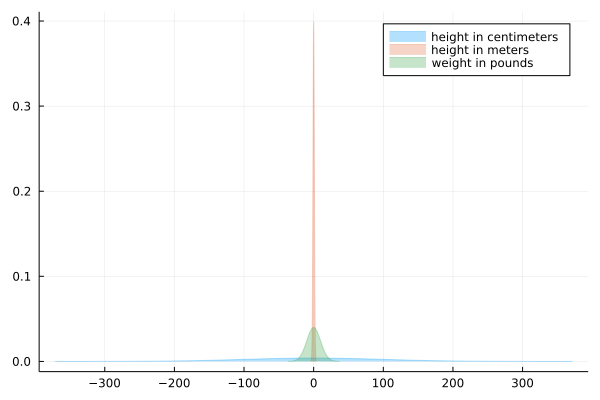

In [7]:
import Pkg; Pkg.add("StatsPlots")
using StatsPlots
plot(Normal(0,100), label = "height in centimeters", fill = true, alpha = 0.3) #highest variance
plot!(Normal(0,1), label = "height in meters", fill = true, alpha = 0.3) #smallest variance
plot!(Normal(0, 10), label = "weight in pounds", fill = true, alpha = 0.3)

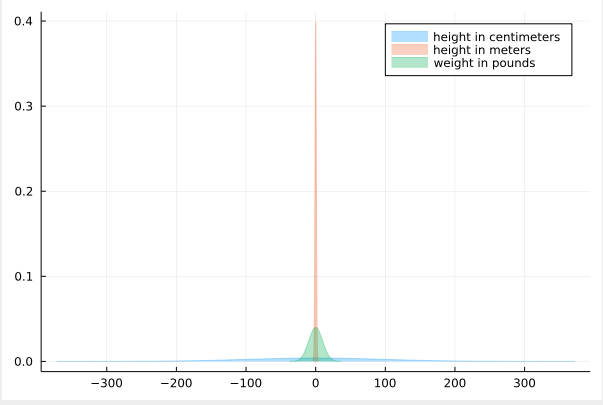

In PCA we are interested in the components that maximize the variance, so if one component varies more than another, PCA determines that the direction of maximal variance more closely corresponds to the axis aligning with that feature. If height is measured in meters and weight in pounds,  PCA would determine that the direction of maximal variance more closely corresponds with the ‘weight’ axis.  Human height varies by small fractions when measured in meters, but weight in pounds can change on the magnitude of 10s and 100s. If we use centimeters instead of meters, then the first component of PCA would now align with the height feature just by virtue of units used.  

To remove these issues, PCA uses scaling as a way to look at each feature apart from the influence of its units.¹ Practically,  variables with low variance increase in importance and those with high variance decrease to even out units' influence.

[¹https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html)

#### Implementation
After this  this preprocessing we can perform SVD, extract a number of principal components, and reproject our data into the original dimension space along the directions of those principal components. 

Because the covariance matrix is symmetric, we can find a basis of singular vectors scaled by the magnitude of the corresponding entry in $Σ$.  In SVD (which produces $UΣV'$) , the first column vector in $V$  corresponds to the largest value in $Σ$ . In this way we have an ordered method of finding the direction of greatest variance and the value associated with that direction. 

We can project our data points from $R^m $ to $R^p$  by using the first $p$  columns of $V$. Using the matrix of first $p$ singular vectors, we can transform our original data to a $p$ -dimensional feature subspace that eliminates the noise we see in other directions. Then, we can either keep everything in $p$ -dimensions or reproject back into $R^m$.  Either way, having successfully preprocessed and implemented SVD based PCA, we are able to get on with the problem we’re trying to solve.

If any of these details of SVD¹or PCA ² are fuzzy, look to the links for a thorough explanation. The quick version, however, is that we transform our data to make it simpler. 


¹[https://towardsdatascience.com/understanding-singular-value-decomposition-and-its-application-in-data-science-388a54be95d](https://towardsdatascience.com/understanding-singular-value-decomposition-and-its-application-in-data-science-388a54be95d)
[²https://jonathan-hui.medium.com/machine-learning-singular-value-decomposition-svd-principal-component-analysis-pca-1d45e885e491 ](https://jonathan-hui.medium.com/machine-learning-singular-value-decomposition-svd-principal-component-analysis-pca-1d45e885e491 )


### But whatever works...


Now that we’ve discussed PCA and why we process our data, we’ll turn our attention to a real life example. After trying different methods of PCA preprocessing, geospatial researchers chose the one with no mean centering and no scaling. However, we first need to set the stage to understand the geospatial discipline.

The research article¹ discussed below and referenced at the beginning of the article is in the domain of remote sensing. Remote sensing has many applications, but I just cover the basics before starting on how PCA was used in a research application. 

[¹https://opengeospatialdata.springeropen.com/articles/10.1186/s40965-017-0029-0](https://opengeospatialdata.springeropen.com/articles/10.1186/s40965-017-0029-0)


#### **Remote Sensing**

Remotely sensed satellite imagery returns a data product after circling the Earth and capturing the surface beneath. The main idea is that satellites return pictures like a standard Red, Green, Blue (RGB) image of your pet dog. You take a picture of Fido, and now you can render his likeness using three color channels coordinated over many pixels. Let's say each of these pixels, perfect squares, represent a hundredth of an inch squared. 

Satellite imagery just makes things a bit more complex. As a satellite orbits the earth, the machine collects the surface reflectance (light) near the surface. However, instead of just imaging the color red,  green, and blue (0.4-0.7 µm wavelength of light), satellites commonly collect 6-8 different wavelengths called bands. These bands trap the signals from very specific ranges of wavelengths, which include some colors we can see and some wavelengths we cannot. For example, the band (0.433-0.453 µm) is particularly useful for discerning aerosols while the range (10.6-11.19 µm) is used to detect heat waves but both are invisible to people. 

Yet, when combined in the right way, different band combinations allow analysts to identify entities like smoke, water, vegetation, and other objects that are invisible to the eye like aerosols or pollution. 

Finally, the last basic consideration is what each pixel means spatially. Each pixel has a single number that represents each band but is also a square that captures a given amount of surface area of the earth. Depending on the satellite, the area can range from 5mx5m to 200x200m. Further,  the number of bands similarly can range from 3-8. 

Below is a visualization of the data structure with 30 meter by 30 meter pixels and 4 bands.
####  

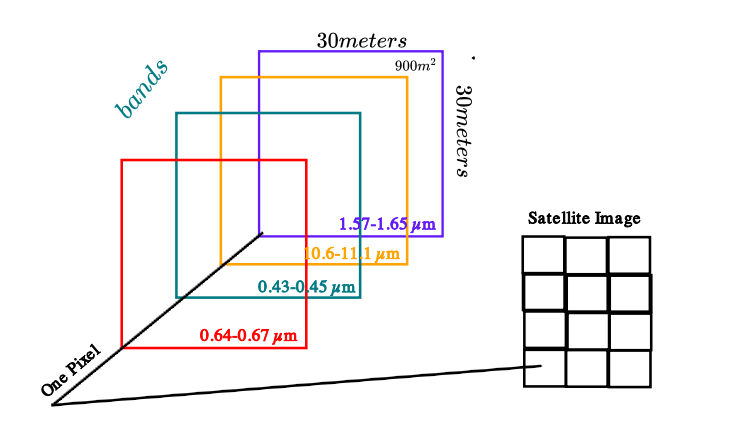

#### The Research Application

In Alexandris’s paper, satellite imagery is used to detect burned land surface areas. This is just one of many general classes of land cover: vegetation, water, urban areas, bare ground, etc. Notably, one pixel in Landsat (one of the satellites used in the paper) covers 900 m² of land surface. Because multiple surface types can be captured in one pixel, different groups can become tangled up.

However, using PCA on a covariance matrix of bands can help separate out the classes of land cover and make for more accurate predictions of classifying the most dominant class represented in each pixel. The main idea is that some combination of the bands gives us a direction of maximal variance along which we can define burned land surface more accurately. This enhances what is termed “the spectral profile” - the defining characteristics  that all pixels in a given class express. In other words, there is a certain profile of wavelengths that make one class of land cover identifiable over others. The more distinct these profiles are, the better our classification gets. Below is a spectral profile of water vs vegetation across the wavelengths blue, green, red, and near-infrared. 

PCA, then, is used to heighten the separability between classes of land cover and make a similarly distinct profile for burned land cover.  

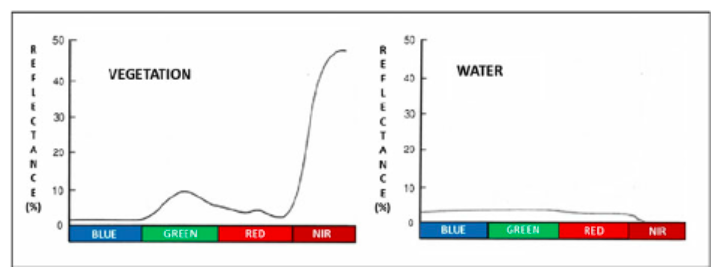

For further illustration, here is the variance-covariance (white cells) and correlation coefficient (grey cells) associated with input surface reflectance bands which were used in the SVD based PCA implementation. While not critical to this discussion on unconventional preprocessing methods, obtaining this matrix allows one to proceed with SVD and gives us a view of the kind of data that was being worked with.

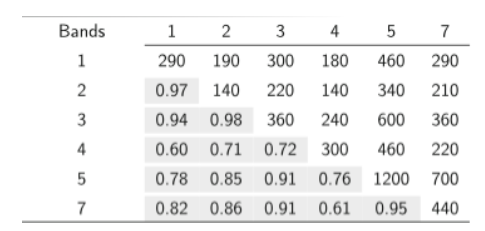

Fig1. Landsat5TM unitemporal postfire: covariance (gray) and 
correlation (white). Numbers along axes designate bands used.

### Unconventional Preprocessing


The purpose of the paper was to combine preprocessing steps in different ways and determine which was the most helpful in separating burned areas from other classes of land cover.  As we noted above, centering shifts the gravity center of the multidimensional dataset toward the origin  while scaling forces unit variance before the analysis. Below are the combinations of centering and scaling that were attempted in the article.¹

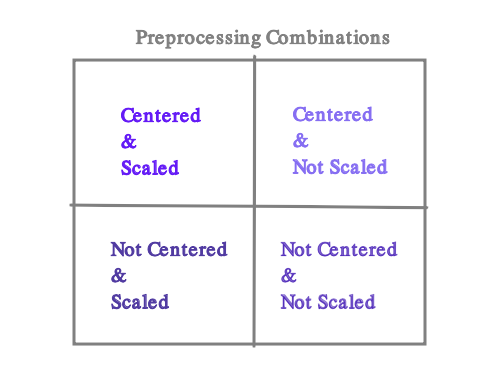

¹ The authors note that scaling non-centered data does not yield to unit variance and is mathematically questionable. However, it was included for completeness.


After implementing PCA, the researchers were interested in the amount of separation between different land cover classes. They assessed separation based on multi-response permutations  and quantified the enhanced spectral separability between burned areas and other major land cover classes via the Jeffries-Matusita (J-M) metric. They evaluated which principal component subset best separated the classes for each preprocessing method¹ on the J-M (not Euclidean) distance between burned ground cover and each of the other classes. 

As an aside, this reference to Jeffries-Matusita metric is similar to Euclidean distance but takes an additional square root of each component. It is a transformation of the Bhatacharyya distance², where we consider the distance as applied to distributions - not just vectors. The J-M has a probabilistic interpretation, that can be used to highlight the separability between burned ground and other land cover classes. 

[¹https://opengeospatialdata.springeropen.com/articles/10.1186/s40965-017-0029-0](https://opengeospatialdata.springeropen.com/articles/10.1186/s40965-017-0029-0) pg6
²[https://en.wikipedia.org/wiki/Bhattacharyya_distance ](https://en.wikipedia.org/wiki/Bhattacharyya_distance )


#### Centering

In this application, only the first four principal components contained meaning and the first had substantially different meanings based on the preprocessing methods. As we noted in our earlier preprocessing discussion about uncentered data, the first PC captures the mean of the data rather than the direction of maximum variance. This seems like a non-optimal situation, but the nature of the data changes that conclusion.

The main reason the best preprocessing (maximum separability) used uncentered data was because of the class of ground cover being investigated. Burned surfaces are recorded as lower reflectance values compared to other classes of land cover. This means that they contribute minimally to the mean.  

 If burned surfaces form data clusters which are clearly separated from the mean, the biggest portion of spectral information is channeled into the 1st uncentered component - resembling features other than the burned class. Alternatively, consider what would happen with centered data. In a point cloud where one class has small positive values and the others have large positive values, shifting the mean to the origin moves the low valued points into negative quadrants. However, the magnitude of these values are potentially larger than before. Then, the relative magnitudes between classes could actually be _more_ similar after centering. 

If we were to use centering in this situation, it would modify the way that data clusters are intercepted by the transformed axes. Effectively, we are "projecting spectral information related to unchanged patterns  in higher order components,"¹  which  works against identifying the spectral profile of burned area land cover. However, if we choose to not scale the data, we can allow the first PC to be associated with the mean as well as  a descriptor of classes **other** than burned areas. Then the 2nd, 3rd, and 4th components would become useful for defining the target class. 

While the logic might make sense, there's something uncomfortable about breaking a standard. Even so, it's important to keep the goal in mind. With PCA, we are delineating boundaries in coherent and verifiable ways, not simply following steps. Thus, when the results show that from all the preprocessing methods the highest separability exists within the uncentered data (and it's verifiable), we should do just that. 

Granted, all of this relies on the target class being a low contributor to the mean, but this paper actually provides a useful insight into how we can use PCA to our advantage in isolating  different classes, albeit unconventionally. 

[¹https://opengeospatialdata.springeropen.com/articles/10.1186/s40965-017-0029-0](https://opengeospatialdata.springeropen.com/articles/10.1186/s40965-017-0029-0) pg 20


#### Scaling

Scaling is used to remove the effects of units from the variance. However, the units in a remote sensing scenario will all be the same because the surface reflectance is being measured across all bands. The difference is just that each band traps different intervals of wavelength. For the bands used in the Alexandris paper, each has a similarly tight interval from which they collect data. That data, in its raw form, will be within the range of values expressible by one byte. In other words, the variance of each band has an upper limit. 

Considering this upper limit of variance, we can then talk about how scaling affects the data.  First, scaling alters the data less than it might when used on continuous features with no upper bound. Further, it distributes more of the variance across principal components. Here, it might be useful to ask yourself what the purpose of scaling is when we have a number of features that all describe the same unit of measurement and each has a similar boundary to maximum variance. 

As revealed in the paper, when we scale data of the same units, we effectively increase those variances of the smaller principal components at the expense of the first principal component. However, considering that the first principal component described the mean of the data when uncentered, distributing the variance associated with the mean across the other principal components actually blurs the distinction of burned areas versus other classes.  In practice, then, scaling essentially smooths out fine variations existing in the original data that might actually be descriptive of the class we're trying to characterize. 

In the end, the "uncentered-scaled version is rather expectedly not useful as it appears to have random effects"¹ and essentially neutralizes potentially useful details through reduced overall separability between classes. 

In the end, the uncentered-unscaled dataset performed the best in SVD based PCA. 

[¹https://opengeospatialdata.springeropen.com/articles/10.1186/s40965-017-0029-0](https://opengeospatialdata.springeropen.com/articles/10.1186/s40965-017-0029-0) pg 20


## Conclusion

Ultimately, the research article we've discussed emphasizes the importance of data-driven choices in implementing models and methods. Discovering the particulars of a project and tuning our approach accordingly is actually a form of inductive bias, where we are forced to make a set of assumptions in order to build understanding and predict outcomes. If these choices have to be made, then it is best to know our project well enough to make them wisely. In the end, there is no single best algorithm for all problems, only that which is optimal for _your _problem - an idea well known via No Free Lunch Theorem . 

Here, we have discussed a small example of these larger concepts. Acknowledging the standard methods of implementing SVD based PCA, we discussed why the preprocessing methods of centering and scaling are used in practice. Then, we explained how geospatial researchers produced more productive results from not following these rules. In essence, their success came from understanding their own data exceptionally well, and recognizing that the underlying reasons for centering and scaling steps did not apply in their case.  

These results might leave you surprised despite the reasoned methodology. However, it is more important to keep the goal in mind before prioritizing the routinized method of achieving it. Across disciplines, those who understand the rules best and know why they are in place are able to remold them in the most productive ways. 

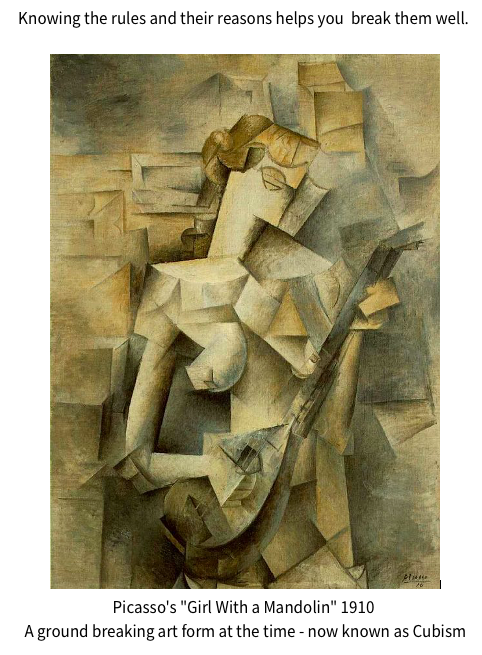

